In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt 
from matplotlib import image
import cartopy
import cartopy.crs as ccrs
import pandas as pd
from datetime import date, timedelta
from dateutil.relativedelta import relativedelta

In [2]:
case = "fanv3_improving"
path = "/glade/scratch/jinmuluo/archive/CanopyReduction/lnd/hist/" 
h = 'h1'
start_date = date(2015, 1, 1)
end_date = date(2015, 12, 1)
delta = end_date - start_date
Input_vars = ['MANURE_N_GRZ', 'MANURE_N_BARNS', 'FERT_N_APP', 'NDEP_TO_SMINN', 'NFIX_TO_SMINN', 
              'FFIX_TO_SMINN', 'FERT_TO_SMINN', 'NITRATE_N_TO_SMINN', 'F_CANOPY_TO_SOIL', 'area', 'landfrac']

Output_vars = ['NH3_TOTAL', 'NH3_MANURE_APP', 'NH3_GRZ', 'NH3_BARNS', 'NH3_STORES', 'NH3_FERT', 
               'NOx_NITRIFY_TOTAL', 'N2O_NITRIFY_TOTAL', 'NOx_DENITRIFY_TOTAL', 'N2O_DENITRIFY_TOTAL', 
               'NOx_TOTAL', 'N2O_TOTAL', 'N2_TOTAL', 
               'MANURE_N_TO_SMINN', 'SYNTHFERT_N_TO_SMINN', 
               'CANOPY_TO_SOIL', 'MANURE_NITRATE_TO_SOIL', 'FERT_NITRATE_TO_SOIL', 
               'MANURE_NH4_RUNOFF', 'FERT_NH4_RUNOFF', 'MANURE_NITRATE_RUNOFF', 'FERT_NITRATE_RUNOFF',
               'F_N2O_NIT', 'F_NOx_NIT', 'F_N2O_DENIT', 'F_NOx_DENIT', 'F_N2_DENIT', 
               'SMIN_NO3_RUNOFF', 'SMIN_NO3_LEACHED', 'area', 'landfrac']

mt_vars = ['MANURE_NO3_TO_SOIL', 'FERT_NO3_TO_SOIL', 'F_NIT', 'F_DENIT', 'ACTUAL_IMMOB_NO3', 'ACTUAL_IMMOB_NH4', 'GROSS_NMIN', 
           'SMIN_NH4_TO_PLANT', 'SMIN_NO3_TO_PLANT', 'SMINN_TO_PLANT_FUN', 'SMINN_TO_PLANT_FUN_NO3', 'SMINN_TO_PLANT_FUN_NH4',
           'area', 'landfrac', 'levdcmp']

fanCLM = []
for i in range(delta.days//30 + 1):
    month = start_date + relativedelta(months=i)
    month = month.strftime('%Y-%m')
    fanCLM.append(path + case + ".clm2." + h + "." + month +".nc")

In [4]:
def preprocess(ds, fields = Output_vars):
    return(ds[fields])

def fix_time(ds):  
    date0 = ds['time'][0].values
    date1 = ds['time'][-1].values
    # ds['time'] =xr.cftime_range(str(yr0),periods=ndays,freq='D')
    ds['time'] = pd.date_range(str(date0),str(date1),freq='MS') 
    
    return ds

dsCLM = fix_time(xr.open_mfdataset(fanCLM, decode_times=True, preprocess=preprocess))
dsCLM

<xarray.Dataset>
Dimensions:                 (time: 12, lat: 96, lon: 144)
Coordinates:
  * time                    (time) datetime64[ns] 2015-02-01 ... 2016-01-01
  * lon                     (lon) float32 0.0 2.5 5.0 7.5 ... 352.5 355.0 357.5
  * lat                     (lat) float32 -90.0 -88.11 -86.21 ... 88.11 90.0
Data variables: (12/31)
    NH3_TOTAL               (time, lat, lon) float32 dask.array<chunksize=(1, 96, 144), meta=np.ndarray>
    NH3_MANURE_APP          (time, lat, lon) float32 dask.array<chunksize=(1, 96, 144), meta=np.ndarray>
    NH3_GRZ                 (time, lat, lon) float32 dask.array<chunksize=(1, 96, 144), meta=np.ndarray>
    NH3_BARNS               (time, lat, lon) float32 dask.array<chunksize=(1, 96, 144), meta=np.ndarray>
    NH3_STORES              (time, lat, lon) float32 dask.array<chunksize=(1, 96, 144), meta=np.ndarray>
    NH3_FERT                (time, lat, lon) float32 dask.array<chunksize=(1, 96, 144), meta=np.ndarray>
    ...                      ...
    F_NOx_DENIT             (time, lat, lon) float32 dask.array<chunksize=(1, 96, 144), meta=np.ndarray>
    F_N2_DENIT              (time, lat, lon) float32 dask.array<chunksize=(1, 96, 144), meta=np.ndarray>
    SMIN_NO3_RUNOFF         (time, lat, lon) float32 dask.array<chunksize=(1, 96, 144), meta=np.ndarray>
    SMIN_NO3_LEACHED        (time, lat, lon) float32 dask.array<chunksize=(1, 96, 144), meta=np.ndarray>
    area                    (time, lat, lon) float32 dask.array<chunksize=(1, 96, 144), meta=np.ndarray>
    landfrac                (time, lat, lon) float32 dask.array<chunksize=(1, 96, 144), meta=np.ndarray>
Attributes: (12/101)
    title:                                CLM History file information
    comment:                              NOTE: None of the variables are wei...
    Conventions:                          CF-1.0
    history:                              created on 05/22/23 21:43:43
    source:                               Community Terrestrial Systems Model
    hostname:                             cheyenne
    ...                                   ...
    cft_irrigated_tropical_corn:          62
    cft_tropical_soybean:                 63
    cft_irrigated_tropical_soybean:       64
    time_period_freq:                     month_1
    Time_constant_3Dvars_filename:        ./fanv3_improving.clm2.h0.2000-01.nc
    Time_constant_3Dvars:                 ZSOI:DZSOI:WATSAT:SUCSAT:BSW:HKSAT:...

In [5]:
def sp_plot(ds, field, coords, show=False):
    sp = ds.sel(lat=coords[0], lon=coords[1], method='nearest')
    if show:
        sp[field].plot(x='time')
        plt.show()
    return sp

In [25]:
def tot_plot(ds, field, show=False, zerol=False, savefig=False):
    # calculate global total emission
    if len(field) > 1:
        for i, var in enumerate(field):
            if i == 0:
                total = ds[var] * ds['area'] * ds['landfrac']
            else:
                total = total + ds[var] * ds['area'] * ds['landfrac']
        total = total.sum(dim=['lat', 'lon'])*0.36*24*30
        total.attrs['units'] = 'GgN/month'
    else:
        var = field[0]
        total = ds[var] * ds['area'] * ds['landfrac']
        total = total.sum(dim=['lat', 'lon'])*0.36*24*30
        total.attrs['units'] = 'GgN/month'
    
    if show:
        total.plot(x='time')
        if zerol:
            x = total.time
            y = np.zeros(len(x))
            plt.plot(x, y, linestyle='dashed', c='black', alpha=0.5)
        plt.title(field)
        plt.ylabel(total.attrs['units'])
        plt.show()
            
    if savefig:
        plt.savefig(field, dpi=150)
    
    return total

In [26]:
def regional_plot(ds, field, coords, show=False):
    x = slice(coords['lower_lat'], coords['upper_lat'])
    y = slice(coords['west_lon'], coords['east_lon'])
    # gN/m2/s to TonN/s
    rp = (ds[field].sel(lat=x, lon=y) * ds['area'].sel(lat=x, lon=y))* ds['landfrac'].sel(lat=x, lon=y).sum(dim=['lat', 'lon'])
    rp.attrs['units'] = 'Tons N/sec'
    if show:
        rp.plot(x='time')
        plt.title(field)
        plt.ylabel(rp.attrs['units'])
        plt.show()
    return rp

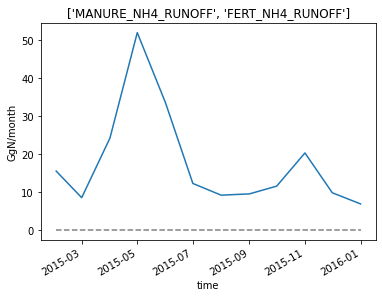

<xarray.DataArray (time: 12)>
dask.array<mul, shape=(12,), dtype=float32, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2015-02-01 2015-03-01 ... 2016-01-01
Attributes:
    units:    GgN/month

In [33]:
tot_plot(ds=dsCLM, field=['MANURE_NH4_RUNOFF', 'FERT_NH4_RUNOFF'], show=True, zerol =True, savefig=False)

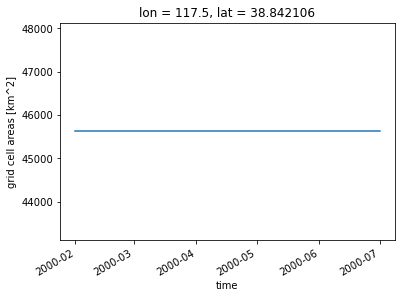

In [9]:
coordinates = [39.24, 116.25]
sp = sp_plot(ds=dsCLM, field=choose_field(h)[4], coords=coordinates, show=True)

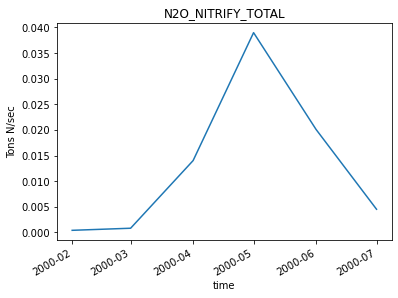

<xarray.DataArray (time: 6)>
dask.array<sum-aggregate, shape=(6,), dtype=float32, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2000-02-01 2000-03-01 ... 2000-07-01
Attributes:
    units:    Tons N/sec

In [10]:
coordinates = {'upper_lat':45.50, 'lower_lat':25.35, 'west_lon': 100.00, 'east_lon':130.00}
regional_plot(ds=dsCLM, field=choose_field(h)[1], coords=coordinates, show=True)